In [9]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Preparation

Import the required libraries, and load edge list data into a graph object.

In [10]:
import torch
import torch.nn as nn

import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F

import dgl
from dgl.nn import SAGEConv
import dgl.function as fn
from sklearn.metrics import roc_auc_score
import itertools

In [11]:
with open('/content/edge.csv', 'r') as f:
    edges = f.readlines()

edges = [edge.strip().split(',') for edge in edges]
categories = edges[0] #['Source', 'Source_name', 'Target', 'Target_name', 'Type', 'Id', 'Label', 'Weight']

# identify source and target nodes and make them tensors
u = torch.tensor([int(edge[0]) for edge in edges[1:]])
v = torch.tensor([int(edge[2]) for edge in edges[1:]])
u_name = [edge[1] for edge in edges[1:]]
v_name = [edge[3] for edge in edges[1:]]
g = dgl.graph((u, v))
# g = dgl.to_bidirected(g) # make the graph bidirectional

# load features
with open('/content/count.csv', 'r') as f:
    count = f.readlines()
count = [c.strip().split(',') for c in count][1:]
count = {c[0]: int(c[1]) for c in count}
count = {f"#{key}": value for key, value in count.items()}

# create a tensor of count values based on the given node IDs
id_name_count = []
for i in range(len(u)):
    id_name_count.append((int(u[i]), u_name[i], count[u_name[i]]))
for i in range(len(v)):
    id_name_count.append((int(v[i]), v_name[i], count[v_name[i]]))
id_name_count = sorted(list(set(id_name_count)))

node_names = [''] + [c[1] for c in id_name_count]
count_tensor = torch.tensor([0] + [c[2] for c in id_name_count])
count_tensor = count_tensor.unsqueeze(1)
g.ndata['feat'] = count_tensor

In [12]:
g

Graph(num_nodes=49, num_edges=795,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.int64)}
      edata_schemes={})

## Prepare training, validation and test data
We split the dataset into the three sets with the ratio of 0.70, 0.15 and 0.15 with random sampling.

In [13]:
eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)

# split into train, val, test
test_size = val_size = int(len(eids) * 0.15)
train_size = len(eids) - val_size - test_size

test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
val_pos_u, val_pos_v = u[eids[test_size:test_size+val_size]], v[eids[test_size:test_size+val_size]]
train_pos_u, train_pos_v = u[eids[test_size+val_size:]], v[eids[test_size+val_size:]]

# find negative edges by randomly sampling from all possible edges.
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(49, 49))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), len(eids))
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size+val_size]], neg_v[neg_eids[test_size:test_size+val_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size:]], neg_v[neg_eids[test_size+val_size:]]

When training, we need to remove the edges in the test set from the original graph via `dgl.remove_edges`. 

In [14]:
train_g = dgl.remove_edges(g, eids[:test_size])

## Define the model

The model consists of two GraphSAGE layers, each computes new node representations by averaging neighbor information. DGL provides ``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.

In [15]:
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

## Create positive and negative edges for training

-  Treat the edges in the graph as *positive examples*.
-  Sample a number of non-existent edges (i.e. node pairs with no edges
   between them) as *negative* examples.
-  Divide the positive examples and negative examples into a training, validation and test set.

In [16]:
# Note: num_nodes was g.number_of_nodes() in the original code
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [17]:
test_pos_g

Graph(num_nodes=49, num_edges=119,
      ndata_schemes={}
      edata_schemes={})

The following code computes new edge features based on the incident nodes' features and the original edge features (if applicable) via `DGLGraph.apply_edges`.

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.

In [18]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

## Training loop

After defining the node representation and edge score computation, the training loop can thus be defined. The evaluation metric is the area under the ROC curve (AUC).

In [19]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [20]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
all_logits = []
l = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'].float())
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    l.append(loss.item())
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

In epoch 0, loss: 2463.833984375
In epoch 5, loss: 483.6066589355469
In epoch 10, loss: 103.05918884277344
In epoch 15, loss: 142.61648559570312
In epoch 20, loss: 88.5102767944336
In epoch 25, loss: 61.44527053833008
In epoch 30, loss: 42.86172866821289
In epoch 35, loss: 28.663013458251953
In epoch 40, loss: 22.353992462158203
In epoch 45, loss: 20.000226974487305
In epoch 50, loss: 17.80171012878418
In epoch 55, loss: 15.992810249328613
In epoch 60, loss: 14.295371055603027
In epoch 65, loss: 12.842416763305664
In epoch 70, loss: 11.677030563354492
In epoch 75, loss: 10.720305442810059
In epoch 80, loss: 9.886724472045898
In epoch 85, loss: 9.262994766235352
In epoch 90, loss: 8.668993949890137
In epoch 95, loss: 8.155742645263672


In [ ]:
l

In [ ]:
np.arange(100)

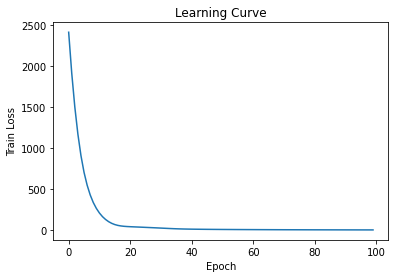

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(100), np.asarray(l))
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

check results

In [ ]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

AUC 0.5297295388743734
